<a href="https://colab.research.google.com/github/nts-e/NLP_Parler_Hate_Detection/blob/main/Parler_Hate_Classification_RUN_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Run 24**

Run description: train a BERT model based on the original annotated data

## Install Transformers Library

In [ ]:
RUN_ID = '24'

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import transformers
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection  import train_test_split
from sklearn.preprocessing    import LabelEncoder
from datetime                 import datetime
from tensorflow.keras         import models, layers, metrics, losses, optimizers, callbacks
from sklearn.metrics          import confusion_matrix, precision_score, recall_score
from tqdm                     import tqdm

RANDOM_STATE                  = 1
USE_GOOGLE_DRIVE_FOR_FILES    = True
DATA_FOLDER_PATH              = "/content/drive/My Drive/Data Science/BGU/NLP/Project/"

if USE_GOOGLE_DRIVE_FOR_FILES:
  from google.colab import drive
  drive.mount('/content/drive')

# distilBERT tokenizer
base_model_name = 'distilbert-base-uncased'
tokenizer = transformers.DistilBertTokenizer.from_pretrained(base_model_name) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Utility methods

In [ ]:
def f1(precision, recall):
  return 2 / ((1/precision) + (1/recall))


def get_confusion_matrix(y_valid, y_pred, labels, precision_recall=True):
  cm = pd.DataFrame(confusion_matrix(y_valid, y_pred, labels=labels))
  cm.columns.name='predicted'
  cm.index.name='actual'

  print(cm)

  if precision_recall:
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    print(f'recall: {recall:.3f}, precision: {precision:.3f}, f1: {f1(precision, recall):.3f}')

## Load Dataset

In [ ]:
df = pd.read_csv(f"{DATA_FOLDER_PATH}parler_annotated_data.csv")
print(df.shape)
df.head(10)

(10121, 4)


,id,text,label_mean,disputable_post
0,a113a2d777ca4211ae97a193eee44dc1,Black men are taught that a word justifies all...,3.60,True
1,bb348c5f20a84be1bc3467d32312341c,Biden and his supporters are claiming that Bid...,4.00,True
2,39df38e04a44423f93ba1d1dc79070c9,Pelosi; âOne way or another Joe Biden will b...,1.25,False
3,68dd325894274be79f73767e92e64702,Northern California Declares Independence From...,3.00,True
4,9503e349140b4bbe9e496f4c0f15f830,Whistleblower claims top DHS officials sought ...,1.50,False
5,61b45f2913bd44a8956ee87cc651cd40,ð´â ï¸â ï¸â ï¸â ï¸â ï¸â ï¸â ï¸...,4.40,False
6,141482eeee684715a2f94aa8240b79bb,Black Chairman of Proud Boys Speaks Out after ...,3.80,False
7,3901049ac6e24ec6949eefa303f84fba,This country is beyond f*cked. The President h...,3.60,True
8,4e4fdf2e34224691ba72860c1af730cd,This is why you build the wall! Democrats are ...,3.40,False
9,cd1f69ffd35a4a28b7983fa400cb941b,"Mask police have no respect from me. ðoff, ...",3.75,False


Following the paper, threshold label_mean > 3 and omit label_mean which is exactly 3:

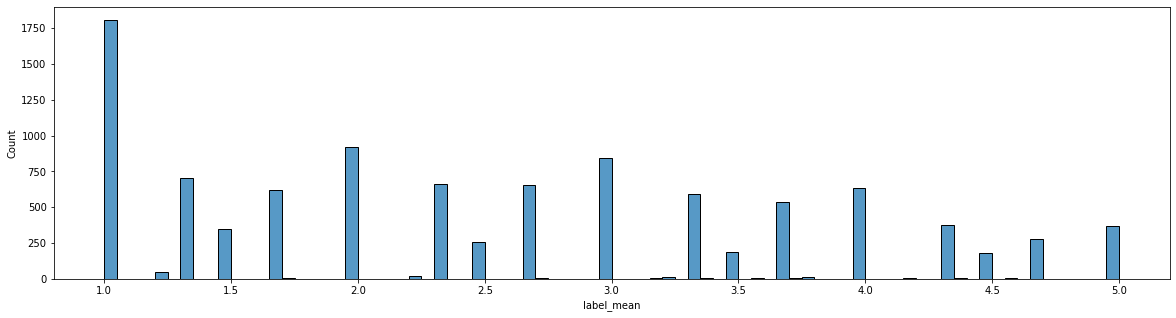

In [ ]:
import seaborn as sns
fig = plt.figure(figsize = (20, 5))
splt = sns.histplot(data=df, x='label_mean',  bins=np.arange(1,5.05,0.05) )

* Set as a binary label
* Remove label_mean = 3

In [ ]:
df['label'] = (df['label_mean']>3).astype('int32')
df = df[df.label_mean!=3]
print(df.shape)

# check class distribution
df['label'].value_counts()

(9277, 5)


0    6053
1    3224
Name: label, dtype: int64

In [ ]:
positive_ratio = df[df.label==1]['label'].sum() / len(df)
positive_ratio

0.3475261399159211

Plot the distribution of label_mean for the negative and positive classes:

* 1805 values from the negative class (~30%) equals 1
* 369 values from the positive class (~11%) equals 5


1805

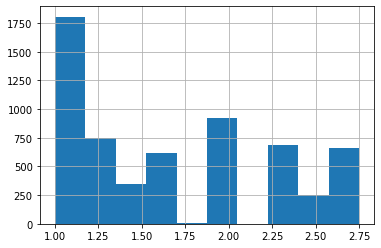

In [ ]:
df[df.label==0]['label_mean'].hist();
df[df.label_mean==1]['label_mean'].count()

369

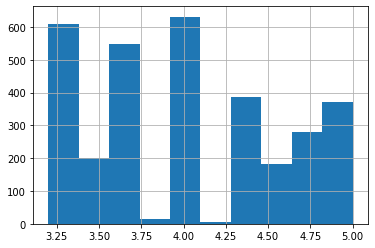

In [ ]:
df[df.label==1]['label_mean'].hist()
df[df.label_mean==5]['label_mean'].count()

This is a generic code to concatenate auxilary training data. 

In this run (24) there's **no additional data** as this is the first BERT.

In [ ]:
mode_of_work = 2     # 1: drop_all_negative_additions; 2: add negative pro rata to the training set; 3: add file as is.

df_loaded_additions = []
df_train_additions = []

for i,d in enumerate(df_loaded_additions):

  d.columns = ['text_clean', 'bert', 'zshot', 'zshot_target']
  d['label'] = -1
  d['zshot'] = d['zshot'].astype('int')
  d.loc[(d.bert==0) & (d.zshot==0), 'label'] = 0
  d.loc[(d.bert==1) & (d.zshot==1) & (d.zshot_target=='0'), 'label'] = 0
  d.loc[(d.bert==1) & (d.zshot==1) & (d.zshot_target!='0'), 'label'] = 1
  d = d.drop(d[d.label==-1].index)
  
  if mode_of_work == 1:
    df_train_additions.append(d.drop(d[d['label']==0].index))
  elif mode_of_work ==2:
    d_negs = d['label'].sum()
    d_pos_to_sample = int( (d_negs / positive_ratio) * (1-positive_ratio))
    temp = d[d.label==0].sample(d_pos_to_sample, random_state=RANDOM_STATE).copy()
    d = d.drop(d[d['label']==0].index)
    df_train_additions.append(pd.concat([d,temp]))
  else:
    df_train_additions.append(d)

In [ ]:
if df_train_additions:
  X_extended = df_train_additions[0]['text_clean']
  y_extended = df_train_additions[0]['label']
else:
  X_extended = pd.Series(dtype='str')
  y_extended = pd.Series(dtype='int')

for i in range(1, len(df_train_additions)):
  X_extended = pd.concat([X_extended, df_train_additions[i]['text_clean']])
  y_extended = pd.concat([y_extended, df_train_additions[i]['label']])
  print(X_extended.shape, "", y_extended.value_counts(), sep="\n")

## EDA

No preprocessing

In [ ]:
df['text_clean'] = df['text']

X = df['text_clean']
y = df['label']

# print an example
df["text_clean"][5]

'ð\x9f\x94´â\x9a\xa0ï¸\x8fâ\x9a\xa0ï¸\x8fâ\x9a\xa0ï¸\x8fâ\x9a\xa0ï¸\x8fâ\x9a\xa0ï¸\x8fâ\x9a\xa0ï¸\x8fâ\x9a\xa0ï¸\x8fâ\x9a\xa0ï¸\x8fâ\x9a\xa0ï¸\x8fâ\x9a\xa0ï¸\x8fâ\x9a\xa0ï¸\x8fLISTEN IF ANYONE DOESNâ\x80\x99T LIKE MY POSTS OF ME CALLING OUT THE CROOKS AND DEEP STATE!! I DONâ\x80\x99T CARE WHAT YOU THINK!!! UNFOLLOW ME OR SHUT THE FUCK UP!!!! IF YOU CANâ\x80\x99T HANDLE THE TRUTH AND WANT YOUR VOTES AND MONEY CONTINUE TO BE STOLEN DONâ\x80\x99T LISTEN!!!!\n\nTHESE CRIMINALS NEED TO BE EXPOSED!!!!\n\nDONâ\x80\x99T LIKE TOO DAMN BAD!!!!!'

## Tokenize and split

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, random_state=RANDOM_STATE, stratify=y_temp)

X_train_and_valid_extended = pd.concat([X_train, X_valid, X_extended])
y_train_and_valid_extended = pd.concat([y_train, y_valid, y_extended])

X_train_and_valid_extended.shape

(7421,)

seq_len=[9, 19, 50, 177, 18, 14, 45, 10, 35, 4, 18, 4, 47, 6, 19, 49, 26, 140, 11, 15, 20, 13, 40, 26, 17, 8, 9, 85, 132, 67, 31, 12, 25, 2, 29, 7, 25, 19, 84, 2, 7, 37, 69, 167, 9, 6, 35, 80, 38, 10, 48, 11, 41, 21, 12, 11, 45, 15, 37, 121, 35, 12, 35, 35, 3, 150, 42, 5, 17, 13, 20, 25, 17, 20, 11, 6, 123, 12, 6, 49, 12, 16, 76, 67, 36, 24, 10, 8, 92, 55, 15, 4, 55, 36, 5, 22, 45, 9, 22, 13, 16, 101, 49, 10, 37, 13, 11, 20, 35, 18, 49, 46, 7, 62, 49, 14, 12, 107, 33, 1, 10, 28, 13, 9, 8, 10, 22, 43, 9, 38, 4, 75, 35, 5, 8, 23, 47, 12, 30, 21, 30, 50, 7, 48, 38, 15, 43, 14, 43, 22, 28, 15, 22, 6, 6, 41, 13, 12, 28, 17, 14, 35, 131, 94, 4, 13, 12, 42, 52, 14, 27, 29, 31, 16, 157, 22, 94, 4, 34, 22, 22, 108, 2, 16, 17, 18, 3, 22, 15, 34, 14, 13, 11, 24, 5, 17, 16, 16, 8, 4, 57, 20, 14, 20, 4, 7, 39, 52, 4, 22, 52, 8, 166, 34, 4, 6, 12, 34, 15, 38, 37, 90, 25, 76, 7, 73, 11, 27, 11, 44, 3, 32, 7, 7, 45, 3, 11, 35, 20, 35, 25, 5, 13, 54, 10, 4, 28, 37, 12, 46, 99, 11, 40, 17, 59, 3, 8, 15,

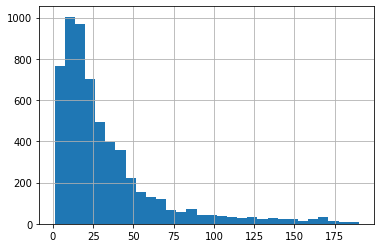

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in X_train]
print(f"seq_len={seq_len}")
print(f"max={max(seq_len)}")

pd.Series(seq_len).hist(bins = 30);
print(f"mean: {np.mean(seq_len):.2f}, std: {np.std(seq_len)}")

In [ ]:
# take max
max_length = 190

In [ ]:
# save a copy of the pre-tokenized X values
X_train_and_valid_extended_copy = X_train_and_valid_extended.copy()
X_test_copy = X_test.copy()

Tokenize and split

In [ ]:
X_train_and_valid_extended = tokenizer(X_train_and_valid_extended.to_list(), padding='max_length', max_length = max_length, truncation=True, return_attention_mask=True)
X_test = tokenizer(X_test.to_list(), padding='max_length', max_length = max_length, truncation=True, return_attention_mask=True)

print(f"{len(X_train_and_valid_extended['input_ids'])} - Train and valid")
print(f"{len(X_test['input_ids'])} - Test")

print("", "Train and valid distribution:",y_train_and_valid_extended.value_counts(), sep="\n")

7421 - Train and valid
1856 - Test

Train and valid distribution:
0    4842
1    2579
dtype: int64


## Load the BERT Transformer

**Fine Tuning**

In [ ]:
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2) # these dropouts are probably useless if the model is not trainable
dbert_tf = transformers.TFDistilBertModel.from_pretrained(base_model_name, config=config, trainable=True) # unfreeze the model

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


## Model Configuration

Typically for a classification task, we use the **only the first** output vector of a sentence as input for the rest of the classification model, since this first vector “encodes” information about the overall text. (alternatively a pooling average of all output vectors could also be used as input for the classifier).


In [ ]:
optimizer = optimizers.Adam(learning_rate=5e-5)
loss = losses.BinaryCrossentropy(from_logits=False) 
metric = [metrics.AUC(from_logits=False), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()] # False because of the sigmoid/softmax

# Define input layers
input_ids_in = layers.Input(shape=(max_length,), name='input_ids', dtype='int32')
input_mask  = layers.Input(shape=(max_length,), name='input_attention', dtype='int32')

# DistilBERT outputs a tuple where the first element at index 0 represents the hidden-state at the output of the model's last layer.
# It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
bert_out = dbert_tf([input_ids_in, input_mask ])[0][:,0,:] # take the first word

x = layers.Dense(128, activation='relu', name="dense_1")(bert_out)
x = layers.Dropout(0.1, name="dropout_1")(x)
x = layers.Dense(32, activation='relu', name="dense_2")(x)
x = layers.Dense(1, activation='sigmoid', name='classification')(x)

model_tf = models.Model(inputs=[input_ids_in,input_mask], outputs = x, name='ClassificationModelTF')
model_tf.compile(optimizer=optimizer,loss=loss, metrics=metric)

model_tf.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")

Model: "ClassificationModelTF"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 190)]        0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 190)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'input_attention[0]

## Train

**Note:** Load the saved version from memory if available

In [ ]:
# model_tf = models.load_model(f'{DATA_FOLDER_PATH}bert_train_and_validation_01.h5', custom_objects={'TFDistilBertModel': dbert_tf})

In [ ]:
# Train the model
start_time = datetime.now()
history = model_tf.fit(
                        x = {'input_ids':np.array(X_train_and_valid_extended['input_ids']), 'input_attention':np.array(X_train_and_valid_extended['attention_mask'])},
                        y = y_train_and_valid_extended,
                        epochs=2,
                        batch_size=32
                    )
end_time = datetime.now()

training_time_tf = (end_time - start_time).total_seconds()

Epoch 1/2
232/232 [==============================] - 145s 582ms/step - loss: 0.4969 - auc: 0.8112 - recall: 0.5568 - precision: 0.6593
Epoch 2/2
232/232 [==============================] - 135s 581ms/step - loss: 0.3611 - auc: 0.9093 - recall: 0.7596 - precision: 0.7713


In [ ]:
metrics_results = model_tf.evaluate({'input_ids':np.array(X_test['input_ids']), 'input_attention':np.array(X_test['attention_mask'])},y_test)

print("AUC:{:.3f}, Recall: {:.3f}, Precision: {:.3f}, F1: {:.3f}".format(metrics_results[1], metrics_results[2], metrics_results[3], f1(metrics_results[2], metrics_results[3])))

58/58 [==============================] - 13s 198ms/step - loss: 0.4410 - auc: 0.8665 - recall: 0.7829 - precision: 0.6558
AUC:0.866, Recall: 0.783, Precision: 0.656, F1: 0.714


In [ ]:
model_tf.save(f'{DATA_FOLDER_PATH}bert_run_{RUN_ID}_epoch_2.h5', save_format='h5')

## Analysis

In [ ]:
threshold = 0.5

predicted_proba_test = model_tf.predict({'input_ids': np.array(X_test['input_ids']), 'input_attention': np.array(X_test['attention_mask'])})
predicted_test = np.array([predicted_proba_test > threshold], dtype=int).flatten()
get_confusion_matrix(y_test, predicted_test, labels=[0,1])

predicted    0    1
actual             
0          946  265
1          140  505
recall: 0.783, precision: 0.656, f1: 0.714


Save results to CSV

In [ ]:
pd.DataFrame(data={'text': X_test_copy, 'y_true': y_test, 'y_pred': predicted_proba_test.flatten()}).to_csv(f'{DATA_FOLDER_PATH}test_predicted_proba_run_{RUN_ID}.csv')